In [7]:
#define path
wesley_ds = "/files"
kaggle_ds = "/archive/Data/genres_original"
main_path = "../raw_dataset"

In [8]:
#choose the dataset
chooser = wesley_ds

In [29]:
DATASET_PATH = main_path+chooser
# DATASET_PATH = "../../../Music"
JSON_PATH = '../pr_dataset/complete_3_first.json'
SAMPLE_RATE = sr =  22050
DURATION = 30 #measured in seconds 
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION

In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(main_path+chooser):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        print(filename)
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3
010. DJ Snake feat. Lauv - A Different Way (.mp3
03 Down On Love (Moksi Remix).mp3
04 Kill It.mp3
04. Tujamo - One On One (Vion Konger Remix) .mp3
10. Sikdope - Snakes (Extended Mix).mp3
10161324_The_Game_Original_Mix.mp3
10582469_Antidote_Extended_Mix.mp3
11073789_Get_Down_Extended_Mix.mp3
205. Diplo And Autoerotique - Waist Time.mp3
4B _ Teez - Whistle (Schade Remix).mp3
9416773_No_More_Original_Mix.mp3
Afrojack - Bassride (Extended Mix) #BassHous.mp3
Albin Myers feat. Bud Stankz - Walking On Wa.mp3
Alenn, NEOX - Spiral [www.slider.kz].mp3
Alesso - Falling (Brohug remix) (125)-1.mp3
Artelax - Crank It (Extended Mix).mp3
AWIIN - Brotality (Extended Mix).mp3
Bart B More - Throwback [www.slider.kz].mp3
Bassride - Congratulations [DemoDrop].mp3
Basstrick - Ghost Buster (Original Mix) [sic.mp3
Be (BROHUG Remix).mp3
Boombox-Cartel---Moon-Love-ft.-Nessly-_Tha-B.mp3
Brohug  - Ambush (Extended Mix) .mp3
BROHUG - Paparazzi (Extended Mix) [www.sl

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
from IPython.display import Audio
# from tqdm import tqdm 
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, Bidirectional, GRU, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import to_categorical
import os
import math
import json
import random
import mutagen

In [30]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=4084, hop_length=1024, num_segments=10):
    #dictionary to store data
    data = {
        'mapping' : [],
        'mfcc' : [],
        'labels' : [],
        'energy': [],
        'key': []
    }
    
    count = 0 # To keep track of our progress
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments) 
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)
    
    #Loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        #ensure that we're not at the root level
        if dirpath not in dataset_path:

            #save the semantic label
            dirpath_components = dirpath.split('/')
            semantic_label = dirpath_components[-1]
            data['mapping'].append(semantic_label)
            print('\nProcessing {}'.format(semantic_label))
            
            #process files for a specific genre 
            for f in filenames:
#                 if f.endswith('.wav') and f != 'jazz.00054.wav': # Since file jazz.00054.wav is an empty file
                if f.endswith('.mp3') or f.endswith('.MP3'): # Since file jazz.00054.wav is an empty file
                    file_path = os.path.join(dirpath,f)
                    
                    #loading the audio file 
                    # we are using the soundfile library since it is faster than librosa
                    signal, sr = librosa.load(file_path) # len(signal) = 661794  # sr is 22050 by default
                    try:
                        temp1 = str(mutagen.File(file_path)['TXXX:EnergyLevel'])
                    
                        temp2 = str(mutagen.File(file_path)['TKEY'])
                    except:
                        continue
                    midptr = int(signal.shape[0]/2)
#                     bptr = midptr - (SAMPLE_RATE*int(DURATION/2)) #set as OFFSET
#                     bptr = signal.shape[0] - SAMPLE_RATE*DURATION
                    bptr = 0
                    #print(signal,sr)
                    #process segments extracting mfcc and storing data
                    for s in range(num_segments): 
                        # Since num_segments is defined as 5. Every 30 sec file is divided into 5 segments of length 6sec 
                        # Start sample would keep track of the index of the first element of each 6 second batch
                        # finish sample would keep track of the index of the last element of each 6 second batch
                        # And then with the help of python's slice functionality we will extract that 6 second batch from every 30 sec signal
                        start_sample = bptr + num_samples_per_segment * s   
                        finish_sample = num_samples_per_segment + start_sample
                        
                        # Next, we will pass each segment in order to extract MFCC. The parameter n_mfcc defines the number of mfcc 
                        # we need to extract, Usually n_mfcc is set b/w 13 to 40. The other parameters n_fft and hop length are 
                        # indivisual topics of discussion. Will be discussed in later Notbooks. 
                        mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample],
                                                   sr = sr,
                                                   n_fft = n_fft,
                                                   n_mfcc = n_mfcc,
                                                   hop_length = hop_length)

                        mfcc = mfcc.T
                        # store mfcc for segment if it has the expected length
                        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                            print(mfcc.shape)
                            data['mfcc'].append(mfcc.tolist())
                            data['labels'].append(i)
                            data['energy'].append(temp1)
                            data['key'].append(temp2)
                            print('Processing {}, segment:{}'.format(file_path, s))
                            count += 1
                            print(count)
    with open(json_path, 'w') as fp:
        json.dump(data, fp, indent=4)

In [31]:
# Let's run the above function 
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing files\BASS HOUSE
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:0
1
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:1
2
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:2
3
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:3
4
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:4
5
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:5
6
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:6
7
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:7
8
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Cast

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\10582469_Antidote_Extended_Mix.mp3, segment:9
80
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:0
81
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:1
82
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:2
83
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:3
84
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:4
85
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:5
86
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:6
87
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:7
88
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, seg

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Alesso - Falling (Brohug remix) (125)-1.mp3, segment:5
156
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Alesso - Falling (Brohug remix) (125)-1.mp3, segment:6
157
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Alesso - Falling (Brohug remix) (125)-1.mp3, segment:7
158
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Alesso - Falling (Brohug remix) (125)-1.mp3, segment:8
159
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Alesso - Falling (Brohug remix) (125)-1.mp3, segment:9
160
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Artelax - Crank It (Extended Mix).mp3, segment:0
161
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Artelax - Crank It (Extended Mix).mp3, segment:1
162
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Artelax - Crank It (Extended Mix).mp3, segment:2
163
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Artelax - Crank It (Extended Mix).mp3, segment:3
164
(65, 13)
Processing ../ra

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Brohug  - Ambush (Extended Mix) .mp3, segment:2
233
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Brohug  - Ambush (Extended Mix) .mp3, segment:3
234
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Brohug  - Ambush (Extended Mix) .mp3, segment:4
235
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Brohug  - Ambush (Extended Mix) .mp3, segment:5
236
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Brohug  - Ambush (Extended Mix) .mp3, segment:6
237
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Brohug  - Ambush (Extended Mix) .mp3, segment:7
238
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Brohug  - Ambush (Extended Mix) .mp3, segment:8
239
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Brohug  - Ambush (Extended Mix) .mp3, segment:9
240
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\BROHUG - Paparazzi (Extended Mix) [www.slide.mp3, segment:0
241
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\D.O.D - Honey [www.slider.kz].mp3, segment:8
309
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\D.O.D - Honey [www.slider.kz].mp3, segment:9
310
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, segment:0
311
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, segment:1
312
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, segment:2
313
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, segment:3
314
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, segment:4
315
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, segment:5
316
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, 

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:1
382
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:2
383
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:3
384
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:4
385
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:5
386
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:6
387
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:7
388
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:8
389
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:9
390
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\FSB _ Jordy 

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Guy Arthur - Get Money (feat. TITUS) [Extend.mp3, segment:6
457
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Guy Arthur - Get Money (feat. TITUS) [Extend.mp3, segment:7
458
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Guy Arthur - Get Money (feat. TITUS) [Extend.mp3, segment:8
459
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Guy Arthur - Get Money (feat. TITUS) [Extend.mp3, segment:9
460
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\HowBoutNo - Turn up (Original Mix).mp3, segment:0
461
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\HowBoutNo - Turn up (Original Mix).mp3, segment:1
462
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\HowBoutNo - Turn up (Original Mix).mp3, segment:2
463
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\HowBoutNo - Turn up (Original Mix).mp3, segment:3
464
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\HowBoutNo - Turn up (Original Mix).mp3, segment:4
465
(65, 1

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jebu - Go Ahead [Музыка Мафия] [www.slider.k.mp3, segment:9
530
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jordan Jay - Be Alright (VIP Mix).mp3, segment:0
531
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jordan Jay - Be Alright (VIP Mix).mp3, segment:1
532
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jordan Jay - Be Alright (VIP Mix).mp3, segment:2
533
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jordan Jay - Be Alright (VIP Mix).mp3, segment:3
534
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jordan Jay - Be Alright (VIP Mix).mp3, segment:4
535
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jordan Jay - Be Alright (VIP Mix).mp3, segment:5
536
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jordan Jay - Be Alright (VIP Mix).mp3, segment:6
537
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jordan Jay - Be Alright (VIP Mix).mp3, segment:7
538
(65, 13)
Processing ../raw_dataset/files\BAS

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\MAKJ _ Michael Sparks - Space Jam (Extended .mp3, segment:7
608
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\MAKJ _ Michael Sparks - Space Jam (Extended .mp3, segment:8
609
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\MAKJ _ Michael Sparks - Space Jam (Extended .mp3, segment:9
610
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Matisse _ Sadko - Takeoff (Extended Mix) [si.mp3, segment:0
611
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Matisse _ Sadko - Takeoff (Extended Mix) [si.mp3, segment:1
612
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Matisse _ Sadko - Takeoff (Extended Mix) [si.mp3, segment:2
613
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Matisse _ Sadko - Takeoff (Extended Mix) [si.mp3, segment:3
614
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Matisse _ Sadko - Takeoff (Extended Mix) [si.mp3, segment:4
615
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Matisse _ Sadko - Ta

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Mightyfools _ MNNR - Shake Ya Body (Extended.mp3, segment:2
683
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Mightyfools _ MNNR - Shake Ya Body (Extended.mp3, segment:3
684
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Mightyfools _ MNNR - Shake Ya Body (Extended.mp3, segment:4
685
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Mightyfools _ MNNR - Shake Ya Body (Extended.mp3, segment:5
686
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Mightyfools _ MNNR - Shake Ya Body (Extended.mp3, segment:6
687
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Mightyfools _ MNNR - Shake Ya Body (Extended.mp3, segment:7
688
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Mightyfools _ MNNR - Shake Ya Body (Extended.mp3, segment:8
689
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Mightyfools _ MNNR - Shake Ya Body (Extended.mp3, segment:9
690
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\MOGUAI, Macon - I Li

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\NONSENS - Make It Pop (Original Mix) [www.sl.mp3, segment:0
761
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\NONSENS - Make It Pop (Original Mix) [www.sl.mp3, segment:1
762
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\NONSENS - Make It Pop (Original Mix) [www.sl.mp3, segment:2
763
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\NONSENS - Make It Pop (Original Mix) [www.sl.mp3, segment:3
764
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\NONSENS - Make It Pop (Original Mix) [www.sl.mp3, segment:4
765
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\NONSENS - Make It Pop (Original Mix) [www.sl.mp3, segment:5
766
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\NONSENS - Make It Pop (Original Mix) [www.sl.mp3, segment:6
767
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\NONSENS - Make It Pop (Original Mix) [www.sl.mp3, segment:7
768
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\NONSENS - Make It Po

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Rock the party (Original Mix).mp3, segment:6
837
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Rock the party (Original Mix).mp3, segment:7
838
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Rock the party (Original Mix).mp3, segment:8
839
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Rock the party (Original Mix).mp3, segment:9
840
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Shade K, Face _ Book - Ballsbuster (Original.mp3, segment:0
841
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Shade K, Face _ Book - Ballsbuster (Original.mp3, segment:1
842
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Shade K, Face _ Book - Ballsbuster (Original.mp3, segment:2
843
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Shade K, Face _ Book - Ballsbuster (Original.mp3, segment:3
844
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Shade K, Face _ Book - Ballsbuster (Original.mp3, segment:4
845
(65, 13)
Process

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Steff Da Campo, twoloud - House Party (Reebs.mp3, segment:0
911
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Steff Da Campo, twoloud - House Party (Reebs.mp3, segment:1
912
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Steff Da Campo, twoloud - House Party (Reebs.mp3, segment:2
913
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Steff Da Campo, twoloud - House Party (Reebs.mp3, segment:3
914
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Steff Da Campo, twoloud - House Party (Reebs.mp3, segment:4
915
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Steff Da Campo, twoloud - House Party (Reebs.mp3, segment:5
916
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Steff Da Campo, twoloud - House Party (Reebs.mp3, segment:6
917
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Steff Da Campo, twoloud - House Party (Reebs.mp3, segment:7
918
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Steff Da Campo, twol

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\WATEVA - Ber Zer Ker [www.slider.kz].mp3, segment:4
985
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\WATEVA - Ber Zer Ker [www.slider.kz].mp3, segment:5
986
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\WATEVA - Ber Zer Ker [www.slider.kz].mp3, segment:6
987
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\WATEVA - Ber Zer Ker [www.slider.kz].mp3, segment:7
988
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\WATEVA - Ber Zer Ker [www.slider.kz].mp3, segment:8
989
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\WATEVA - Ber Zer Ker [www.slider.kz].mp3, segment:9
990
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Why So Serious - Familiar [www.slider.kz].mp3, segment:0
991
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Why So Serious - Familiar [www.slider.kz].mp3, segment:1
992
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Why So Serious - Familiar [www.slider.kz].mp3, segment:2
993
(65, 13)
Proc

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 ARTIN - Hydra (Extended Mix).mp3, segment:9
1060
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Bigenesis _ Jadon Fonka - Fluto (Extended.mp3, segment:0
1061
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Bigenesis _ Jadon Fonka - Fluto (Extended.mp3, segment:1
1062
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Bigenesis _ Jadon Fonka - Fluto (Extended.mp3, segment:2
1063
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Bigenesis _ Jadon Fonka - Fluto (Extended.mp3, segment:3
1064
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Bigenesis _ Jadon Fonka - Fluto (Extended.mp3, segment:4
1065
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Bigenesis _ Jadon Fonka - Fluto (Extended.mp3, segment:5
1066
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Bigenesis _ Jadon Fonka - Fluto (Extended.mp3, segment:6
1067
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Bigenesis _ Jadon Fonka - Fluto (Extende

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 KEVU - Octagon (Extended Mix).mp3, segment:3
1134
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 KEVU - Octagon (Extended Mix).mp3, segment:4
1135
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 KEVU - Octagon (Extended Mix).mp3, segment:5
1136
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 KEVU - Octagon (Extended Mix).mp3, segment:6
1137
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 KEVU - Octagon (Extended Mix).mp3, segment:7
1138
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 KEVU - Octagon (Extended Mix).mp3, segment:8
1139
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 KEVU - Octagon (Extended Mix).mp3, segment:9
1140
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 KEVU _ Steven Vegas - Tribu (Extended Mix.mp3, segment:0
1141
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 KEVU _ Steven Vegas - Tribu (Extended Mix.mp3, segment:1
1142
(65, 13)
Processing ../raw_dataset/files\BIG ROOM

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Repow - Fogo (Extended Mix).mp3, segment:9
1210
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Sebastian Mateo _ Zinko - Pompero (Extend.mp3, segment:0
1211
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Sebastian Mateo _ Zinko - Pompero (Extend.mp3, segment:1
1212
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Sebastian Mateo _ Zinko - Pompero (Extend.mp3, segment:2
1213
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Sebastian Mateo _ Zinko - Pompero (Extend.mp3, segment:3
1214
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Sebastian Mateo _ Zinko - Pompero (Extend.mp3, segment:4
1215
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Sebastian Mateo _ Zinko - Pompero (Extend.mp3, segment:5
1216
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Sebastian Mateo _ Zinko - Pompero (Extend.mp3, segment:6
1217
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Sebastian Mateo _ Zinko - Pompero (Extend

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\010_SMH_Lost Night.mp3, segment:4
1285
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\010_SMH_Lost Night.mp3, segment:5
1286
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\010_SMH_Lost Night.mp3, segment:6
1287
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\010_SMH_Lost Night.mp3, segment:7
1288
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\010_SMH_Lost Night.mp3, segment:8
1289
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\010_SMH_Lost Night.mp3, segment:9
1290
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\02 How Do You Feel Right Now x Yeah x Pjanoo.mp3, segment:0
1291
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\02 How Do You Feel Right Now x Yeah x Pjanoo.mp3, segment:1
1292
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\02 How Do You Feel Right Now x Yeah x Pjanoo.mp3, segment:2
1293
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\02 How Do You Feel Right Now x Yeah x Pjanoo.mp3, segment:3
1294
(65, 1

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\10702433_Tear_This_Mother_Down__feat__MX2__E.mp3, segment:1
1362
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\10702433_Tear_This_Mother_Down__feat__MX2__E.mp3, segment:2
1363
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\10702433_Tear_This_Mother_Down__feat__MX2__E.mp3, segment:3
1364
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\10702433_Tear_This_Mother_Down__feat__MX2__E.mp3, segment:4
1365
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\10702433_Tear_This_Mother_Down__feat__MX2__E.mp3, segment:5
1366
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\10702433_Tear_This_Mother_Down__feat__MX2__E.mp3, segment:6
1367
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\10702433_Tear_This_Mother_Down__feat__MX2__E.mp3, segment:7
1368
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\10702433_Tear_This_Mother_Down__feat__MX2__E.mp3, segment:8
1369
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\10702433_Tear_This_Mother_Down

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\12388778_Ritual_MOSKA_Extended_Remix.mp3, segment:9
1440
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\13. TBR - Atomic vs. One Republic - Counting.mp3, segment:0
1441
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\13. TBR - Atomic vs. One Republic - Counting.mp3, segment:1
1442
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\13. TBR - Atomic vs. One Republic - Counting.mp3, segment:2
1443
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\13. TBR - Atomic vs. One Republic - Counting.mp3, segment:3
1444
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\13. TBR - Atomic vs. One Republic - Counting.mp3, segment:4
1445
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\13. TBR - Atomic vs. One Republic - Counting.mp3, segment:5
1446
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\13. TBR - Atomic vs. One Republic - Counting.mp3, segment:6
1447
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\13. TBR - Atomic vs. One Republic - Co

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\61. Afrojack vs KSHMR _ Cash Cash - Take 123.mp3, segment:4
1515
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\61. Afrojack vs KSHMR _ Cash Cash - Take 123.mp3, segment:5
1516
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\61. Afrojack vs KSHMR _ Cash Cash - Take 123.mp3, segment:6
1517
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\61. Afrojack vs KSHMR _ Cash Cash - Take 123.mp3, segment:7
1518
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\61. Afrojack vs KSHMR _ Cash Cash - Take 123.mp3, segment:8
1519
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\61. Afrojack vs KSHMR _ Cash Cash - Take 123.mp3, segment:9
1520
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\7019310_Pounce_Original_Mix.mp3, segment:0
1521
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\7019310_Pounce_Original_Mix.mp3, segment:1
1522
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\7019310_Pounce_Original_Mix.mp3, segment:2
1523
(65, 13)
Process

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Afrojack, Fedde Le Grand, MC Ambush - 1234 (.mp3, segment:0
1591
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Afrojack, Fedde Le Grand, MC Ambush - 1234 (.mp3, segment:1
1592
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Afrojack, Fedde Le Grand, MC Ambush - 1234 (.mp3, segment:2
1593
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Afrojack, Fedde Le Grand, MC Ambush - 1234 (.mp3, segment:3
1594
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Afrojack, Fedde Le Grand, MC Ambush - 1234 (.mp3, segment:4
1595
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Afrojack, Fedde Le Grand, MC Ambush - 1234 (.mp3, segment:5
1596
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Afrojack, Fedde Le Grand, MC Ambush - 1234 (.mp3, segment:6
1597
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Afrojack, Fedde Le Grand, MC Ambush - 1234 (.mp3, segment:7
1598
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Afrojack, Fedde Le Grand, MC A

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Armin van Buuren _ Blasterjaxx - Tarzan (Ext.mp3, segment:2
1663
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Armin van Buuren _ Blasterjaxx - Tarzan (Ext.mp3, segment:3
1664
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Armin van Buuren _ Blasterjaxx - Tarzan (Ext.mp3, segment:4
1665
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Armin van Buuren _ Blasterjaxx - Tarzan (Ext.mp3, segment:5
1666
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Armin van Buuren _ Blasterjaxx - Tarzan (Ext.mp3, segment:6
1667
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Armin van Buuren _ Blasterjaxx - Tarzan (Ext.mp3, segment:7
1668
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Armin van Buuren _ Blasterjaxx - Tarzan (Ext.mp3, segment:8
1669
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Armin van Buuren _ Blasterjaxx - Tarzan (Ext.mp3, segment:9
1670
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Armin van Buuren _ Jamis - Boo

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bali Bandits - Fire In Your Soul (feat. Mike.mp3, segment:7
1738
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bali Bandits - Fire In Your Soul (feat. Mike.mp3, segment:8
1739
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bali Bandits - Fire In Your Soul (feat. Mike.mp3, segment:9
1740
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers - Snatch (Extended Mix) [www.sli.mp3, segment:0
1741
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers - Snatch (Extended Mix) [www.sli.mp3, segment:1
1742
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers - Snatch (Extended Mix) [www.sli.mp3, segment:2
1743
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers - Snatch (Extended Mix) [www.sli.mp3, segment:3
1744
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers - Snatch (Extended Mix) [www.sli.mp3, segment:4
1745
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers - Snatch (Extended

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - No Sleep (Extended Mix) [www.s.mp3, segment:0
1811
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - No Sleep (Extended Mix) [www.s.mp3, segment:1
1812
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - No Sleep (Extended Mix) [www.s.mp3, segment:2
1813
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - No Sleep (Extended Mix) [www.s.mp3, segment:3
1814
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - No Sleep (Extended Mix) [www.s.mp3, segment:4
1815
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - No Sleep (Extended Mix) [www.s.mp3, segment:5
1816
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - No Sleep (Extended Mix) [www.s.mp3, segment:6
1817
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - No Sleep (Extended Mix) [www.s.mp3, segment:7
1818
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - No Sleep (Extend

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Breach Back (TURQEY Mashup).mp3, segment:4
1885
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Breach Back (TURQEY Mashup).mp3, segment:5
1886
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Breach Back (TURQEY Mashup).mp3, segment:6
1887
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Breach Back (TURQEY Mashup).mp3, segment:7
1888
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Breach Back (TURQEY Mashup).mp3, segment:8
1889
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Breach Back (TURQEY Mashup).mp3, segment:9
1890
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\BreakdeX _ Dastven - Pardo (Extended Mix).mp3, segment:0
1891
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\BreakdeX _ Dastven - Pardo (Extended Mix).mp3, segment:1
1892
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\BreakdeX _ Dastven - Pardo (Extended Mix).mp3, segment:2
1893
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\BreakdeX _ Dastven - Pardo

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmatico (Extended M.mp3, segment:0
1961
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmatico (Extended M.mp3, segment:1
1962
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmatico (Extended M.mp3, segment:2
1963
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmatico (Extended M.mp3, segment:3
1964
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmatico (Extended M.mp3, segment:4
1965
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmatico (Extended M.mp3, segment:5
1966
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmatico (Extended M.mp3, segment:6
1967
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmatico (Extended M.mp3, segment:7
1968
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmati

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dance All Night vs. BARRACA (New Sound Natio.mp3, segment:4
2035
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dance All Night vs. BARRACA (New Sound Natio.mp3, segment:5
2036
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dance All Night vs. BARRACA (New Sound Natio.mp3, segment:6
2037
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dance All Night vs. BARRACA (New Sound Natio.mp3, segment:7
2038
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dance All Night vs. BARRACA (New Sound Natio.mp3, segment:8
2039
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dance All Night vs. BARRACA (New Sound Natio.mp3, segment:9
2040
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dannic _ Bougenvilla - Ctrl Alt Del (WCM) [w.mp3, segment:0
2041
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dannic _ Bougenvilla - Ctrl Alt Del (WCM) [w.mp3, segment:1
2042
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dannic _ Bougenvilla - Ctrl Al

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dirty Ducks _ Hawkboy - Outlaw (Extended Mix.mp3, segment:7
2108
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dirty Ducks _ Hawkboy - Outlaw (Extended Mix.mp3, segment:8
2109
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dirty Ducks _ Hawkboy - Outlaw (Extended Mix.mp3, segment:9
2110
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dj Snake feat Justin Bieber- Let Me Love You.mp3, segment:0
2111
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dj Snake feat Justin Bieber- Let Me Love You.mp3, segment:1
2112
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dj Snake feat Justin Bieber- Let Me Love You.mp3, segment:2
2113
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dj Snake feat Justin Bieber- Let Me Love You.mp3, segment:3
2114
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dj Snake feat Justin Bieber- Let Me Love You.mp3, segment:4
2115
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dj Snake feat Justin Bieber- L

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Eliminate - Weeble Wobble (Original Mix) [Tr.mp3, segment:0
2181
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Eliminate - Weeble Wobble (Original Mix) [Tr.mp3, segment:1
2182
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Eliminate - Weeble Wobble (Original Mix) [Tr.mp3, segment:2
2183
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Eliminate - Weeble Wobble (Original Mix) [Tr.mp3, segment:3
2184
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Eliminate - Weeble Wobble (Original Mix) [Tr.mp3, segment:4
2185
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Eliminate - Weeble Wobble (Original Mix) [Tr.mp3, segment:5
2186
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Eliminate - Weeble Wobble (Original Mix) [Tr.mp3, segment:6
2187
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Eliminate - Weeble Wobble (Original Mix) [Tr.mp3, segment:7
2188
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Eliminate - Weeble Wobble (Ori

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\FTampa - F.I.A. (Extended Mix) [www.slider.k.mp3, segment:8
2259
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\FTampa - F.I.A. (Extended Mix) [www.slider.k.mp3, segment:9
2260
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Futuristic Polar Bears _ Maddix - Lynx (Exte.mp3, segment:0
2261
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Futuristic Polar Bears _ Maddix - Lynx (Exte.mp3, segment:1
2262
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Futuristic Polar Bears _ Maddix - Lynx (Exte.mp3, segment:2
2263
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Futuristic Polar Bears _ Maddix - Lynx (Exte.mp3, segment:3
2264
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Futuristic Polar Bears _ Maddix - Lynx (Exte.mp3, segment:4
2265
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Futuristic Polar Bears _ Maddix - Lynx (Exte.mp3, segment:5
2266
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Futuristic Polar Bears _ Maddi

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell - Being Alive (feat. JGUAR) [Extend.mp3, segment:2
2333
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell - Being Alive (feat. JGUAR) [Extend.mp3, segment:3
2334
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell - Being Alive (feat. JGUAR) [Extend.mp3, segment:4
2335
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell - Being Alive (feat. JGUAR) [Extend.mp3, segment:5
2336
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell - Being Alive (feat. JGUAR) [Extend.mp3, segment:6
2337
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell - Being Alive (feat. JGUAR) [Extend.mp3, segment:7
2338
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell - Being Alive (feat. JGUAR) [Extend.mp3, segment:8
2339
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell - Being Alive (feat. JGUAR) [Extend.mp3, segment:9
2340
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell - Encoded (Ben Amberg

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Quintino - Woest (Extended Mix).mp3, segment:4
2405
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Quintino - Woest (Extended Mix).mp3, segment:5
2406
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Quintino - Woest (Extended Mix).mp3, segment:6
2407
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Quintino - Woest (Extended Mix).mp3, segment:7
2408
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Quintino - Woest (Extended Mix).mp3, segment:8
2409
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Quintino - Woest (Extended Mix).mp3, segment:9
2410
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Sick Individuals - Get Low (Exten.mp3, segment:0
2411
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Sick Individuals - Get Low (Exten.mp3, segment:1
2412
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Sick Individuals - Get Low (Ext

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Henry Fong, Halfway House feat. Sanjin - F.E.mp3, segment:6
2477
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Henry Fong, Halfway House feat. Sanjin - F.E.mp3, segment:7
2478
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Henry Fong, Halfway House feat. Sanjin - F.E.mp3, segment:8
2479
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Henry Fong, Halfway House feat. Sanjin - F.E.mp3, segment:9
2480
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Higher Baller Way (Marx Mashup).mp3, segment:0
2481
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Higher Baller Way (Marx Mashup).mp3, segment:1
2482
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Higher Baller Way (Marx Mashup).mp3, segment:2
2483
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Higher Baller Way (Marx Mashup).mp3, segment:3
2484
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Higher Baller Way (Marx Mashup).mp3, segment:4
2485
(65, 13)
Processing ../raw_dat

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway _ Mike Cervello - EDM Bubble (Ex.mp3, segment:4
2555
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway _ Mike Cervello - EDM Bubble (Ex.mp3, segment:5
2556
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway _ Mike Cervello - EDM Bubble (Ex.mp3, segment:6
2557
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway _ Mike Cervello - EDM Bubble (Ex.mp3, segment:7
2558
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway _ Mike Cervello - EDM Bubble (Ex.mp3, segment:8
2559
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway _ Mike Cervello - EDM Bubble (Ex.mp3, segment:9
2560
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway — Aliens (KARIOKO Festival Edit).mp3, segment:0
2561
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway — Aliens (KARIOKO Festival Edit).mp3, segment:1
2562
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway — Aliens (KARIOKO 

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kaaze — Sexy (Steven Vegas Extended Mix).mp3, segment:7
2628
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kaaze — Sexy (Steven Vegas Extended Mix).mp3, segment:8
2629
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kaaze — Sexy (Steven Vegas Extended Mix).mp3, segment:9
2630
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\KAAZE, KSHMR, Karra - Devil Inside Me (feat..mp3, segment:0
2631
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\KAAZE, KSHMR, Karra - Devil Inside Me (feat..mp3, segment:1
2632
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\KAAZE, KSHMR, Karra - Devil Inside Me (feat..mp3, segment:2
2633
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\KAAZE, KSHMR, Karra - Devil Inside Me (feat..mp3, segment:3
2634
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\KAAZE, KSHMR, Karra - Devil Inside Me (feat..mp3, segment:4
2635
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\KAAZE, KSHMR, Karra - Devil Inside Me (fea

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Krexxton - Levitate (Extended Mix).mp3, segment:0
2701
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Krexxton - Levitate (Extended Mix).mp3, segment:1
2702
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Krexxton - Levitate (Extended Mix).mp3, segment:2
2703
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Krexxton - Levitate (Extended Mix).mp3, segment:3
2704
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Krexxton - Levitate (Extended Mix).mp3, segment:4
2705
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Krexxton - Levitate (Extended Mix).mp3, segment:5
2706
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Krexxton - Levitate (Extended Mix).mp3, segment:6
2707
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Krexxton - Levitate (Extended Mix).mp3, segment:7
2708
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Krexxton - Levitate (Extended Mix).mp3, segment:8
2709
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Krexx

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\LMNTRX _ CAMARDA - I Wanna See (Extended Mix.mp3, segment:6
2777
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\LMNTRX _ CAMARDA - I Wanna See (Extended Mix.mp3, segment:7
2778
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\LMNTRX _ CAMARDA - I Wanna See (Extended Mix.mp3, segment:8
2779
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\LMNTRX _ CAMARDA - I Wanna See (Extended Mix.mp3, segment:9
2780
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Luke Bond - Clockwork [www.slider.kz].mp3, segment:0
2781
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Luke Bond - Clockwork [www.slider.kz].mp3, segment:1
2782
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Luke Bond - Clockwork [www.slider.kz].mp3, segment:2
2783
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Luke Bond - Clockwork [www.slider.kz].mp3, segment:3
2784
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Luke Bond - Clockwork [www.slider.kz].mp3, segment:4
2785


(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maddix-JUNIOR-Trabanca-Extended-Mix.mp3, segment:9
2850
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Madison Mars - Back 2 Underground (Extended .mp3, segment:0
2851
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Madison Mars - Back 2 Underground (Extended .mp3, segment:1
2852
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Madison Mars - Back 2 Underground (Extended .mp3, segment:2
2853
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Madison Mars - Back 2 Underground (Extended .mp3, segment:3
2854
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Madison Mars - Back 2 Underground (Extended .mp3, segment:4
2855
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Madison Mars - Back 2 Underground (Extended .mp3, segment:5
2856
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Madison Mars - Back 2 Underground (Extended .mp3, segment:6
2857
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Madison Mars - Back 2 Underground (Exte

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - What the F_! (Extended Mix) [.mp3, segment:2
2923
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - What the F_! (Extended Mix) [.mp3, segment:3
2924
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - What the F_! (Extended Mix) [.mp3, segment:4
2925
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - What the F_! (Extended Mix) [.mp3, segment:5
2926
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - What the F_! (Extended Mix) [.mp3, segment:6
2927
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - What the F_! (Extended Mix) [.mp3, segment:7
2928
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - What the F_! (Extended Mix) [.mp3, segment:8
2929
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - What the F_! (Extended Mix) [.mp3, segment:9
2930
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Merzo - Crypto [www.slider.kz]

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mike Williams - Day Or Night (Extended Mix) .mp3, segment:6
2997
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mike Williams - Day Or Night (Extended Mix) .mp3, segment:7
2998
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mike Williams - Day Or Night (Extended Mix) .mp3, segment:8
2999
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mike Williams - Day Or Night (Extended Mix) .mp3, segment:9
3000
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\MorganJ - Let It Go (Extended Mix) [www.slid.mp3, segment:0
3001
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\MorganJ - Let It Go (Extended Mix) [www.slid.mp3, segment:1
3002
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\MorganJ - Let It Go (Extended Mix) [www.slid.mp3, segment:2
3003
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\MorganJ - Let It Go (Extended Mix) [www.slid.mp3, segment:3
3004
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\MorganJ - Let It Go (Extended 

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\NAEMS, WYKO _ Krexxton - Smoking (Extended M.mp3, segment:9
3070
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Neil Bronson Vs. Skytune - Wild (Original Mi.mp3, segment:0
3071
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Neil Bronson Vs. Skytune - Wild (Original Mi.mp3, segment:1
3072
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Neil Bronson Vs. Skytune - Wild (Original Mi.mp3, segment:2
3073
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Neil Bronson Vs. Skytune - Wild (Original Mi.mp3, segment:3
3074
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Neil Bronson Vs. Skytune - Wild (Original Mi.mp3, segment:4
3075
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Neil Bronson Vs. Skytune - Wild (Original Mi.mp3, segment:5
3076
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Neil Bronson Vs. Skytune - Wild (Original Mi.mp3, segment:6
3077
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Neil Bronson Vs. Skytune - Wil

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Notalike _ Dirty Ducks - I Can_#39_t Take It.mp3, segment:1
3142
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Notalike _ Dirty Ducks - I Can_#39_t Take It.mp3, segment:2
3143
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Notalike _ Dirty Ducks - I Can_#39_t Take It.mp3, segment:3
3144
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Notalike _ Dirty Ducks - I Can_#39_t Take It.mp3, segment:4
3145
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Notalike _ Dirty Ducks - I Can_#39_t Take It.mp3, segment:5
3146
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Notalike _ Dirty Ducks - I Can_#39_t Take It.mp3, segment:6
3147
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Notalike _ Dirty Ducks - I Can_#39_t Take It.mp3, segment:7
3148
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Notalike _ Dirty Ducks - I Can_#39_t Take It.mp3, segment:8
3149
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Notalike _ Dirty Ducks - I Can

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino - Underground (Extended Mix) [www.s.mp3, segment:4
3215
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino - Underground (Extended Mix) [www.s.mp3, segment:5
3216
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino - Underground (Extended Mix) [www.s.mp3, segment:6
3217
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino - Underground (Extended Mix) [www.s.mp3, segment:7
3218
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino - Underground (Extended Mix) [www.s.mp3, segment:8
3219
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino - Underground (Extended Mix) [www.s.mp3, segment:9
3220
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino x nFiX _ Candice - Zoo Adventure (E.mp3, segment:0
3221
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino x nFiX _ Candice - Zoo Adventure (E.mp3, segment:1
3222
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino x nFiX _ Candice - Zo

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Reggio _ Sansixto — Invasion (Original Mix).mp3, segment:6
3287
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Reggio _ Sansixto — Invasion (Original Mix).mp3, segment:7
3288
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Reggio _ Sansixto — Invasion (Original Mix).mp3, segment:8
3289
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Reggio _ Sansixto — Invasion (Original Mix).mp3, segment:9
3290
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Retrovision - Get Down (Extended Mix) www.li.mp3, segment:0
3291
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Retrovision - Get Down (Extended Mix) www.li.mp3, segment:1
3292
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Retrovision - Get Down (Extended Mix) www.li.mp3, segment:2
3293
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Retrovision - Get Down (Extended Mix) www.li.mp3, segment:3
3294
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Retrovision - Get Down (Extended M

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Scheffwell _ Bastian H.  - Next Level (Orgin.mp3, segment:0
3361
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Scheffwell _ Bastian H.  - Next Level (Orgin.mp3, segment:1
3362
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Scheffwell _ Bastian H.  - Next Level (Orgin.mp3, segment:2
3363
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Scheffwell _ Bastian H.  - Next Level (Orgin.mp3, segment:3
3364
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Scheffwell _ Bastian H.  - Next Level (Orgin.mp3, segment:4
3365
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Scheffwell _ Bastian H.  - Next Level (Orgin.mp3, segment:5
3366
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Scheffwell _ Bastian H.  - Next Level (Orgin.mp3, segment:6
3367
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Scheffwell _ Bastian H.  - Next Level (Orgin.mp3, segment:7
3368
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Scheffwell _ Bastian H.  - Nex

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sick Individuals - LUNA (Extended Mix) [www..mp3, segment:4
3435
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sick Individuals - LUNA (Extended Mix) [www..mp3, segment:5
3436
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sick Individuals - LUNA (Extended Mix) [www..mp3, segment:6
3437
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sick Individuals - LUNA (Extended Mix) [www..mp3, segment:7
3438
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sick Individuals - LUNA (Extended Mix) [www..mp3, segment:8
3439
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sick Individuals - LUNA (Extended Mix) [www..mp3, segment:9
3440
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sick Individuals x Jewelz _ Sparks - Reactio.mp3, segment:0
3441
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sick Individuals x Jewelz _ Sparks - Reactio.mp3, segment:1
3442
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sick Individuals x Jewelz _ Sp

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steve Aoki - GIRL (Deorro _ Dave Mak Remix) .mp3, segment:7
3508
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steve Aoki - GIRL (Deorro _ Dave Mak Remix) .mp3, segment:8
3509
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steve Aoki - GIRL (Deorro _ Dave Mak Remix) .mp3, segment:9
3510
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steve Aoki x Quintino - Mayhem (Original Mix.mp3, segment:0
3511
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steve Aoki x Quintino - Mayhem (Original Mix.mp3, segment:1
3512
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steve Aoki x Quintino - Mayhem (Original Mix.mp3, segment:2
3513
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steve Aoki x Quintino - Mayhem (Original Mix.mp3, segment:3
3514
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steve Aoki x Quintino - Mayhem (Original Mix.mp3, segment:4
3515
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steve Aoki x Quintino - Mayhem

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:0
3581
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:1
3582
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:2
3583
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:3
3584
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:4
3585
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:5
3586
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:6
3587
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:7
3588
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:8
3589
(65, 13)
Processing ../raw_dataset/fi

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tiesto _ Dzeko - Jackie Chan (Tiesto Big Roo.mp3, segment:5
3656
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tiesto _ Dzeko - Jackie Chan (Tiesto Big Roo.mp3, segment:6
3657
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tiesto _ Dzeko - Jackie Chan (Tiesto Big Roo.mp3, segment:7
3658
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tiesto _ Dzeko - Jackie Chan (Tiesto Big Roo.mp3, segment:8
3659
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tiesto _ Dzeko - Jackie Chan (Tiesto Big Roo.mp3, segment:9
3660
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tiesto, MOTi - Break The House Down (Extende.mp3, segment:0
3661
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tiesto, MOTi - Break The House Down (Extende.mp3, segment:1
3662
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tiesto, MOTi - Break The House Down (Extende.mp3, segment:2
3663
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tiesto, MOTi - Break The House

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tony Junior, Reggio - S4YM (Extended Mix) [w.mp3, segment:7
3728
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tony Junior, Reggio - S4YM (Extended Mix) [w.mp3, segment:8
3729
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tony Junior, Reggio - S4YM (Extended Mix) [w.mp3, segment:9
3730
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\TRICKY [Wukileak].mp3, segment:0
3731
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\TRICKY [Wukileak].mp3, segment:1
3732
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\TRICKY [Wukileak].mp3, segment:2
3733
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\TRICKY [Wukileak].mp3, segment:3
3734
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\TRICKY [Wukileak].mp3, segment:4
3735
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\TRICKY [Wukileak].mp3, segment:5
3736
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\TRICKY [Wukileak].mp3, segment:6
3737
(65, 13)
Processing ../raw_dataset/file

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Window _ Marcell Caztrino - Burn Out (Extend.mp3, segment:3
3804
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Window _ Marcell Caztrino - Burn Out (Extend.mp3, segment:4
3805
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Window _ Marcell Caztrino - Burn Out (Extend.mp3, segment:5
3806
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Window _ Marcell Caztrino - Burn Out (Extend.mp3, segment:6
3807
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Window _ Marcell Caztrino - Burn Out (Extend.mp3, segment:7
3808
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Window _ Marcell Caztrino - Burn Out (Extend.mp3, segment:8
3809
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Window _ Marcell Caztrino - Burn Out (Extend.mp3, segment:9
3810
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Wiwek - LMLOYFF (Original Mix).MP3, segment:0
3811
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Wiwek - LMLOYFF (Original Mix).MP3, segment:

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\ZINKO - WEK [www.slider.kz].mp3, segment:7
3878
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\ZINKO - WEK [www.slider.kz].mp3, segment:8
3879
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\ZINKO - WEK [www.slider.kz].mp3, segment:9
3880
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\_WYNE Remix.mp3, segment:0
3881
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\_WYNE Remix.mp3, segment:1
3882
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\_WYNE Remix.mp3, segment:2
3883
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\_WYNE Remix.mp3, segment:3
3884
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\_WYNE Remix.mp3, segment:4
3885
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\_WYNE Remix.mp3, segment:5
3886
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\_WYNE Remix.mp3, segment:6
3887
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\_WYNE Remix.mp3, segment:7
3888
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\

(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\13490344_The_Bender_Club_Edit.mp3, segment:6
3957
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\13490344_The_Bender_Club_Edit.mp3, segment:7
3958
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\13490344_The_Bender_Club_Edit.mp3, segment:8
3959
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\13490344_The_Bender_Club_Edit.mp3, segment:9
3960
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Alesso _ SUMR CAMP - In The Middle (Extended.mp3, segment:0
3961
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Alesso _ SUMR CAMP - In The Middle (Extended.mp3, segment:1
3962
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Alesso _ SUMR CAMP - In The Middle (Extended.mp3, segment:2
3963
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Alesso _ SUMR CAMP - In The Middle (Extended.mp3, segment:3
3964
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Alesso _ SUMR CAMP - In The Middle (Extended.mp3, segment:4
3965
(65, 13

(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Guy Burns - Lie Machine [www.slider.kz].mp3, segment:0
4031
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Guy Burns - Lie Machine [www.slider.kz].mp3, segment:1
4032
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Guy Burns - Lie Machine [www.slider.kz].mp3, segment:2
4033
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Guy Burns - Lie Machine [www.slider.kz].mp3, segment:3
4034
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Guy Burns - Lie Machine [www.slider.kz].mp3, segment:4
4035
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Guy Burns - Lie Machine [www.slider.kz].mp3, segment:5
4036
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Guy Burns - Lie Machine [www.slider.kz].mp3, segment:6
4037
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Guy Burns - Lie Machine [www.slider.kz].mp3, segment:7
4038
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Guy Burns - Lie Machine [www.slider.kz].mp3, segment

(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Loud Luxury - Body feat brando (PBH _ Jack S.mp3, segment:2
4103
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Loud Luxury - Body feat brando (PBH _ Jack S.mp3, segment:3
4104
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Loud Luxury - Body feat brando (PBH _ Jack S.mp3, segment:4
4105
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Loud Luxury - Body feat brando (PBH _ Jack S.mp3, segment:5
4106
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Loud Luxury - Body feat brando (PBH _ Jack S.mp3, segment:6
4107
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Loud Luxury - Body feat brando (PBH _ Jack S.mp3, segment:7
4108
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Loud Luxury - Body feat brando (PBH _ Jack S.mp3, segment:8
4109
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Loud Luxury - Body feat brando (PBH _ Jack S.mp3, segment:9
4110
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Low Steppa -

(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Marshmello feat. Halsey - Be Kind (Denis Fir.mp3, segment:4
4175
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Marshmello feat. Halsey - Be Kind (Denis Fir.mp3, segment:5
4176
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Marshmello feat. Halsey - Be Kind (Denis Fir.mp3, segment:6
4177
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Marshmello feat. Halsey - Be Kind (Denis Fir.mp3, segment:7
4178
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Marshmello feat. Halsey - Be Kind (Denis Fir.mp3, segment:8
4179
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Marshmello feat. Halsey - Be Kind (Denis Fir.mp3, segment:9
4180
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Martin Garrix, Khalid - Ocean (Bart B More E.mp3, segment:0
4181
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Martin Garrix, Khalid - Ocean (Bart B More E.mp3, segment:1
4182
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Martin Garri

(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\PuFFcorn _ Showmain - Don_t Give Up Remix Tr.mp3, segment:6
4247
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\PuFFcorn _ Showmain - Don_t Give Up Remix Tr.mp3, segment:7
4248
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\PuFFcorn _ Showmain - Don_t Give Up Remix Tr.mp3, segment:8
4249
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\PuFFcorn _ Showmain - Don_t Give Up Remix Tr.mp3, segment:9
4250
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Qubiko - Love Like This (Extended Mix).mp3, segment:0
4251
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Qubiko - Love Like This (Extended Mix).mp3, segment:1
4252
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Qubiko - Love Like This (Extended Mix).mp3, segment:2
4253
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Qubiko - Love Like This (Extended Mix).mp3, segment:3
4254
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Qubiko - Love Like This (Extended Mi

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\01 Zheno _ NO-ONE -  For A Minute (Extended .mp3, segment:7
4318
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\01 Zheno _ NO-ONE -  For A Minute (Extended .mp3, segment:8
4319
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\01 Zheno _ NO-ONE -  For A Minute (Extended .mp3, segment:9
4320
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\12835712_Drumkore_Extended_Mix.mp3, segment:0
4321
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\12835712_Drumkore_Extended_Mix.mp3, segment:1
4322
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\12835712_Drumkore_Extended_Mix.mp3, segment:2
4323
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\12835712_Drumkore_Extended_Mix.mp3, segment:3
4324
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\12835712_Drumkore_Extended_Mix.mp3, segment:4
4325
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\12835712_Drumkore_Extended_Mix.mp3, segment:5
4326
(65,

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\62. Blinders vs Jonas Aden x Castion _ Aeden.mp3, segment:0
4391
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\62. Blinders vs Jonas Aden x Castion _ Aeden.mp3, segment:1
4392
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\62. Blinders vs Jonas Aden x Castion _ Aeden.mp3, segment:2
4393
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\62. Blinders vs Jonas Aden x Castion _ Aeden.mp3, segment:3
4394
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\62. Blinders vs Jonas Aden x Castion _ Aeden.mp3, segment:4
4395
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\62. Blinders vs Jonas Aden x Castion _ Aeden.mp3, segment:5
4396
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\62. Blinders vs Jonas Aden x Castion _ Aeden.mp3, segment:6
4397
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\62. Blinders vs Jonas Aden x Castion _ Aeden.mp3, segment:7
4398
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Bali Bandits - Fire In Your Soul (feat. Mike.mp3, segment:9
4460
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Botnek - Gimme That Juice (Extended Mix) [ww.mp3, segment:0
4461
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Botnek - Gimme That Juice (Extended Mix) [ww.mp3, segment:1
4462
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Botnek - Gimme That Juice (Extended Mix) [ww.mp3, segment:2
4463
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Botnek - Gimme That Juice (Extended Mix) [ww.mp3, segment:3
4464
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Botnek - Gimme That Juice (Extended Mix) [ww.mp3, segment:4
4465
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Botnek - Gimme That Juice (Extended Mix) [ww.mp3, segment:5
4466
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Botnek - Gimme That Juice (Extended Mix) [ww.mp3, segment:6
4467
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:0
4531
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:1
4532
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:2
4533
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:3
4534
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:4
4535
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:5
4536
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:6
4537
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:7
4538
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:8
4539
(65, 13)
Processing ../raw_dataset/fi

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Fisher - Losing It (Dave Winnel _For The Win.mp3, segment:0
4601
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Fisher - Losing It (Dave Winnel _For The Win.mp3, segment:1
4602
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Fisher - Losing It (Dave Winnel _For The Win.mp3, segment:2
4603
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Fisher - Losing It (Dave Winnel _For The Win.mp3, segment:3
4604
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Fisher - Losing It (Dave Winnel _For The Win.mp3, segment:4
4605
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Fisher - Losing It (Dave Winnel _For The Win.mp3, segment:5
4606
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Fisher - Losing It (Dave Winnel _For The Win.mp3, segment:6
4607
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Fisher - Losing It (Dave Winnel _For The Win.mp3, segment:7
4608
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\KYANU - Coming Back (Extended Mix) [www.slid.mp3, segment:0
4671
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\KYANU - Coming Back (Extended Mix) [www.slid.mp3, segment:1
4672
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\KYANU - Coming Back (Extended Mix) [www.slid.mp3, segment:2
4673
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\KYANU - Coming Back (Extended Mix) [www.slid.mp3, segment:3
4674
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\KYANU - Coming Back (Extended Mix) [www.slid.mp3, segment:4
4675
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\KYANU - Coming Back (Extended Mix) [www.slid.mp3, segment:5
4676
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\KYANU - Coming Back (Extended Mix) [www.slid.mp3, segment:6
4677
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\KYANU - Coming Back (Extended Mix) [www.slid.mp3, segment:7
4678
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\METAFO4R - Rave Machine (Extended Mix) [www..mp3, segment:0
4741
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\METAFO4R - Rave Machine (Extended Mix) [www..mp3, segment:1
4742
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\METAFO4R - Rave Machine (Extended Mix) [www..mp3, segment:2
4743
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\METAFO4R - Rave Machine (Extended Mix) [www..mp3, segment:3
4744
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\METAFO4R - Rave Machine (Extended Mix) [www..mp3, segment:4
4745
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\METAFO4R - Rave Machine (Extended Mix) [www..mp3, segment:5
4746
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\METAFO4R - Rave Machine (Extended Mix) [www..mp3, segment:6
4747
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\METAFO4R - Rave Machine (Extended Mix) [www..mp3, segment:7
4748
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\NiM - SWACQ - Work My Body (Extended Mix) [w.mp3, segment:0
4811
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\NiM - SWACQ - Work My Body (Extended Mix) [w.mp3, segment:1
4812
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\NiM - SWACQ - Work My Body (Extended Mix) [w.mp3, segment:2
4813
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\NiM - SWACQ - Work My Body (Extended Mix) [w.mp3, segment:3
4814
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\NiM - SWACQ - Work My Body (Extended Mix) [w.mp3, segment:4
4815
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\NiM - SWACQ - Work My Body (Extended Mix) [w.mp3, segment:5
4816
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\NiM - SWACQ - Work My Body (Extended Mix) [w.mp3, segment:6
4817
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\NiM - SWACQ - Work My Body (Extended Mix) [w.mp3, segment:7
4818
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Rob _ Jack - I Got U (Extended Mix).mp3, segment:0
4881
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Rob _ Jack - I Got U (Extended Mix).mp3, segment:1
4882
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Rob _ Jack - I Got U (Extended Mix).mp3, segment:2
4883
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Rob _ Jack - I Got U (Extended Mix).mp3, segment:3
4884
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Rob _ Jack - I Got U (Extended Mix).mp3, segment:4
4885
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Rob _ Jack - I Got U (Extended Mix).mp3, segment:5
4886
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Rob _ Jack - I Got U (Extended Mix).mp3, segment:6
4887
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Rob _ Jack - I Got U (Extended Mix).mp3, segment:7
4888
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Rob _ Jack - I Got U (Extended Mix).mp3, segment:8
4889
(

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Timmy Trumpet _ Max Vangeli - Booty Shake_Em.mp3, segment:0
4951
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Timmy Trumpet _ Max Vangeli - Booty Shake_Em.mp3, segment:1
4952
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Timmy Trumpet _ Max Vangeli - Booty Shake_Em.mp3, segment:2
4953
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Timmy Trumpet _ Max Vangeli - Booty Shake_Em.mp3, segment:3
4954
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Timmy Trumpet _ Max Vangeli - Booty Shake_Em.mp3, segment:4
4955
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Timmy Trumpet _ Max Vangeli - Booty Shake_Em.mp3, segment:5
4956
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Timmy Trumpet _ Max Vangeli - Booty Shake_Em.mp3, segment:6
4957
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Timmy Trumpet _ Max Vangeli - Booty Shake_Em.mp3, segment:7
4958
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Turn The Bass Up vs. Instinct (New Sound Nat.mp3, segment:0
5021
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Turn The Bass Up vs. Instinct (New Sound Nat.mp3, segment:1
5022
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Turn The Bass Up vs. Instinct (New Sound Nat.mp3, segment:2
5023
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Turn The Bass Up vs. Instinct (New Sound Nat.mp3, segment:3
5024
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Turn The Bass Up vs. Instinct (New Sound Nat.mp3, segment:4
5025
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Turn The Bass Up vs. Instinct (New Sound Nat.mp3, segment:5
5026
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Turn The Bass Up vs. Instinct (New Sound Nat.mp3, segment:6
5027
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Turn The Bass Up vs. Instinct (New Sound Nat.mp3, segment:7
5028
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Wiwek, Gregor Salto - Azumba [www.slider.kz].mp3, segment:2
5093
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Wiwek, Gregor Salto - Azumba [www.slider.kz].mp3, segment:3
5094
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Wiwek, Gregor Salto - Azumba [www.slider.kz].mp3, segment:4
5095
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Wiwek, Gregor Salto - Azumba [www.slider.kz].mp3, segment:5
5096
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Wiwek, Gregor Salto - Azumba [www.slider.kz].mp3, segment:6
5097
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Wiwek, Gregor Salto - Azumba [www.slider.kz].mp3, segment:7
5098
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Wiwek, Gregor Salto - Azumba [www.slider.kz].mp3, segment:8
5099
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Wiwek, Gregor Salto - Azumba [www.slider.kz].mp3, segment:9
5100
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\01 PØP CULTUR _ Marc Joef - On The Dancefloo.mp3, segment:2
5163
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\01 PØP CULTUR _ Marc Joef - On The Dancefloo.mp3, segment:3
5164
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\01 PØP CULTUR _ Marc Joef - On The Dancefloo.mp3, segment:4
5165
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\01 PØP CULTUR _ Marc Joef - On The Dancefloo.mp3, segment:5
5166
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\01 PØP CULTUR _ Marc Joef - On The Dancefloo.mp3, segment:6
5167
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\01 PØP CULTUR _ Marc Joef - On The Dancefloo.mp3, segment:7
5168
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\01 PØP CULTUR _ Marc Joef - On The Dancefloo.mp3, segment:8
5169
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\01 PØP CULTUR _ Marc Joef - On The Dancefloo.mp3, segment:9
5170
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\15. Conor Ross - Next Level vs. Avicii - Wak.mp3, segment:5
5236
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\15. Conor Ross - Next Level vs. Avicii - Wak.mp3, segment:6
5237
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\15. Conor Ross - Next Level vs. Avicii - Wak.mp3, segment:7
5238
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\15. Conor Ross - Next Level vs. Avicii - Wak.mp3, segment:8
5239
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\15. Conor Ross - Next Level vs. Avicii - Wak.mp3, segment:9
5240
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\55. Tujamo x LOTTEN vs Macklemore _ LIV SHOR.mp3, segment:0
5241
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\55. Tujamo x LOTTEN vs Macklemore _ LIV SHOR.mp3, segment:1
5242
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\55. Tujamo x LOTTEN vs Macklemore _ LIV SHOR.mp3, segment:2
5243
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Asketa _ Natan Chaim, Kyle Reynolds - Real L.mp3, segment:4
5305
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Asketa _ Natan Chaim, Kyle Reynolds - Real L.mp3, segment:5
5306
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Asketa _ Natan Chaim, Kyle Reynolds - Real L.mp3, segment:6
5307
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Asketa _ Natan Chaim, Kyle Reynolds - Real L.mp3, segment:7
5308
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Asketa _ Natan Chaim, Kyle Reynolds - Real L.mp3, segment:8
5309
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Asketa _ Natan Chaim, Kyle Reynolds - Real L.mp3, segment:9
5310
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Avicii feat Aloe Blacc Vs Robert Miles Vs Zo.mp3, segment:0
5311
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Avicii feat Aloe Blacc Vs Robert Miles Vs Zo.mp3, segment:1
5312
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Bougenvilla - Onik  [www.slider.kz].mp3, segment:4
5375
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Bougenvilla - Onik  [www.slider.kz].mp3, segment:5
5376
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Bougenvilla - Onik  [www.slider.kz].mp3, segment:6
5377
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Bougenvilla - Onik  [www.slider.kz].mp3, segment:7
5378
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Bougenvilla - Onik  [www.slider.kz].mp3, segment:8
5379
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Bougenvilla - Onik  [www.slider.kz].mp3, segment:9
5380
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Bounce Inc. - Nobody Likes (Extended Mix) [w.mp3, segment:0
5381
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Bounce Inc. - Nobody Likes (Extended Mix) [w.mp3, segment:1
5382
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Bounce Inc. - Nobody Likes (Extended Mix) [w.mp3

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Curbi _ Mesto vs. Icona Pop - BRUH I Love It.mp3, segment:8
5449
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Curbi _ Mesto vs. Icona Pop - BRUH I Love It.mp3, segment:9
5450
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Cytrax _ Dexum - Lies (Extended Mix).mp3, segment:0
5451
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Cytrax _ Dexum - Lies (Extended Mix).mp3, segment:1
5452
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Cytrax _ Dexum - Lies (Extended Mix).mp3, segment:2
5453
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Cytrax _ Dexum - Lies (Extended Mix).mp3, segment:3
5454
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Cytrax _ Dexum - Lies (Extended Mix).mp3, segment:4
5455
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Cytrax _ Dexum - Lies (Extended Mix).mp3, segment:5
5456
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Cytrax _ Dexum - Lies (Extended Mix).mp3, 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Dirty Ducks - Your Love (Extended Mix).mp3, segment:9
5520
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Dj Marlon - Story Of My Life (Original Mix).mp3, segment:0
5521
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Dj Marlon - Story Of My Life (Original Mix).mp3, segment:1
5522
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Dj Marlon - Story Of My Life (Original Mix).mp3, segment:2
5523
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Dj Marlon - Story Of My Life (Original Mix).mp3, segment:3
5524
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Dj Marlon - Story Of My Life (Original Mix).mp3, segment:4
5525
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Dj Marlon - Story Of My Life (Original Mix).mp3, segment:5
5526
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Dj Marlon - Story Of My Life (Original Mix).mp3, segment:6
5527
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Dj Marl

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF, David Puentez - Put Your Hands Up (Orig.mp3, segment:2
5593
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF, David Puentez - Put Your Hands Up (Orig.mp3, segment:3
5594
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF, David Puentez - Put Your Hands Up (Orig.mp3, segment:4
5595
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF, David Puentez - Put Your Hands Up (Orig.mp3, segment:5
5596
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF, David Puentez - Put Your Hands Up (Orig.mp3, segment:6
5597
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF, David Puentez - Put Your Hands Up (Orig.mp3, segment:7
5598
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF, David Puentez - Put Your Hands Up (Orig.mp3, segment:8
5599
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF, David Puentez - Put Your Hands Up (Orig.mp3, segment:9
5600
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\EKAE _ KRMA - Skylights (Extended Mix).mp3, segment:1
5662
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\EKAE _ KRMA - Skylights (Extended Mix).mp3, segment:2
5663
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\EKAE _ KRMA - Skylights (Extended Mix).mp3, segment:3
5664
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\EKAE _ KRMA - Skylights (Extended Mix).mp3, segment:4
5665
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\EKAE _ KRMA - Skylights (Extended Mix).mp3, segment:5
5666
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\EKAE _ KRMA - Skylights (Extended Mix).mp3, segment:6
5667
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\EKAE _ KRMA - Skylights (Extended Mix).mp3, segment:7
5668
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\EKAE _ KRMA - Skylights (Extended Mix).mp3, segment:8
5669
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\EKAE _ KRMA - Skylights (Extended Mix).mp3

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Funky Fool - Go Back (Extended).mp3, segment:2
5733
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Funky Fool - Go Back (Extended).mp3, segment:3
5734
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Funky Fool - Go Back (Extended).mp3, segment:4
5735
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Funky Fool - Go Back (Extended).mp3, segment:5
5736
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Funky Fool - Go Back (Extended).mp3, segment:6
5737
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Funky Fool - Go Back (Extended).mp3, segment:7
5738
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Funky Fool - Go Back (Extended).mp3, segment:8
5739
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Funky Fool - Go Back (Extended).mp3, segment:9
5740
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\G6 Trantrum (MOAM _ PATRICKW Mashup).mp3, segment:0
5741
(65, 13)
Processing ../raw_dataset/files\

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Jonas Aden - My Love Is Gone (Extended Mix) .mp3, segment:5
5876
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Jonas Aden - My Love Is Gone (Extended Mix) .mp3, segment:6
5877
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Jonas Aden - My Love Is Gone (Extended Mix) .mp3, segment:7
5878
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Jonas Aden - My Love Is Gone (Extended Mix) .mp3, segment:8
5879
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Jonas Aden - My Love Is Gone (Extended Mix) .mp3, segment:9
5880
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\JRVO _ Roman Blanco - Not Your Kind (Extende.mp3, segment:0
5881
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\JRVO _ Roman Blanco - Not Your Kind (Extende.mp3, segment:1
5882
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\JRVO _ Roman Blanco - Not Your Kind (Extende.mp3, segment:2
5883
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\KYANU - Higher Off The Ground (Day Mix) (WCM.mp3, segment:4
5945
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\KYANU - Higher Off The Ground (Day Mix) (WCM.mp3, segment:5
5946
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\KYANU - Higher Off The Ground (Day Mix) (WCM.mp3, segment:6
5947
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\KYANU - Higher Off The Ground (Day Mix) (WCM.mp3, segment:7
5948
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\KYANU - Higher Off The Ground (Day Mix) (WCM.mp3, segment:8
5949
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\KYANU - Higher Off The Ground (Day Mix) (WCM.mp3, segment:9
5950
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Larsema _ Alexis B - My Heart (Extended Mix).mp3, segment:0
5951
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Larsema _ Alexis B - My Heart (Extended Mix).mp3, segment:1
5952
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Lost Frequencies vs. Mike Williams _ Brooks .mp3, segment:4
6015
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Lost Frequencies vs. Mike Williams _ Brooks .mp3, segment:5
6016
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Lost Frequencies vs. Mike Williams _ Brooks .mp3, segment:6
6017
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Lost Frequencies vs. Mike Williams _ Brooks .mp3, segment:7
6018
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Lost Frequencies vs. Mike Williams _ Brooks .mp3, segment:8
6019
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Lost Frequencies vs. Mike Williams _ Brooks .mp3, segment:9
6020
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\LVIS - YOUNG Master.mp3, segment:0
6021
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\LVIS - YOUNG Master.mp3, segment:1
6022
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\LVIS - YOUNG Master.mp3, segment:2
6023
(65,

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash - You_re Not Alone [www.slider.kz].mp3, segment:6
6087
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash - You_re Not Alone [www.slider.kz].mp3, segment:7
6088
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash - You_re Not Alone [www.slider.kz].mp3, segment:8
6089
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash - You_re Not Alone [www.slider.kz].mp3, segment:9
6090
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash x Pharien - Marathon (Extended Mix.mp3, segment:0
6091
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash x Pharien - Marathon (Extended Mix.mp3, segment:1
6092
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash x Pharien - Marathon (Extended Mix.mp3, segment:2
6093
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash x Pharien - Marathon (Extended Mix.mp3, segment:3
6094
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\MIMO _ Camden Levine ft. Emma Remelle - Sour.mp3, segment:6
6157
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\MIMO _ Camden Levine ft. Emma Remelle - Sour.mp3, segment:7
6158
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\MIMO _ Camden Levine ft. Emma Remelle - Sour.mp3, segment:8
6159
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\MIMO _ Camden Levine ft. Emma Remelle - Sour.mp3, segment:9
6160
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\NERVO _ 7 Skies - Love On Me (Extended Mix) .mp3, segment:0
6161
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\NERVO _ 7 Skies - Love On Me (Extended Mix) .mp3, segment:1
6162
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\NERVO _ 7 Skies - Love On Me (Extended Mix) .mp3, segment:2
6163
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\NERVO _ 7 Skies - Love On Me (Extended Mix) .mp3, segment:3
6164
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Paul King - In The Club.mp3, segment:8
6229
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Paul King - In The Club.mp3, segment:9
6230
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pexem, Schella - New Funk Sound [www.slider..mp3, segment:0
6231
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pexem, Schella - New Funk Sound [www.slider..mp3, segment:1
6232
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pexem, Schella - New Funk Sound [www.slider..mp3, segment:2
6233
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pexem, Schella - New Funk Sound [www.slider..mp3, segment:3
6234
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pexem, Schella - New Funk Sound [www.slider..mp3, segment:4
6235
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pexem, Schella - New Funk Sound [www.slider..mp3, segment:5
6236
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pexem, Schella - New Funk Sound [www

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\RetroVision - Feel Your Touch (Extended Mix).mp3, segment:9
6300
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Rich James _ Pyro - Don_t Leave (Extended Mi.mp3, segment:0
6301
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Rich James _ Pyro - Don_t Leave (Extended Mi.mp3, segment:1
6302
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Rich James _ Pyro - Don_t Leave (Extended Mi.mp3, segment:2
6303
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Rich James _ Pyro - Don_t Leave (Extended Mi.mp3, segment:3
6304
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Rich James _ Pyro - Don_t Leave (Extended Mi.mp3, segment:4
6305
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Rich James _ Pyro - Don_t Leave (Extended Mi.mp3, segment:5
6306
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Rich James _ Pyro - Don_t Leave (Extended Mi.mp3, segment:6
6307
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Siks - Next Level (Extended Mix) www.livinge.mp3, segment:0
6371
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Siks - Next Level (Extended Mix) www.livinge.mp3, segment:1
6372
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Siks - Next Level (Extended Mix) www.livinge.mp3, segment:2
6373
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Siks - Next Level (Extended Mix) www.livinge.mp3, segment:3
6374
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Siks - Next Level (Extended Mix) www.livinge.mp3, segment:4
6375
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Siks - Next Level (Extended Mix) www.livinge.mp3, segment:5
6376
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Siks - Next Level (Extended Mix) www.livinge.mp3, segment:6
6377
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Siks - Next Level (Extended Mix) www.livinge.mp3, segment:7
6378
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff Da Campo _ David Puentez - Everybody (.mp3, segment:0
6441
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff Da Campo _ David Puentez - Everybody (.mp3, segment:1
6442
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff Da Campo _ David Puentez - Everybody (.mp3, segment:2
6443
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff Da Campo _ David Puentez - Everybody (.mp3, segment:3
6444
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff Da Campo _ David Puentez - Everybody (.mp3, segment:4
6445
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff Da Campo _ David Puentez - Everybody (.mp3, segment:5
6446
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff Da Campo _ David Puentez - Everybody (.mp3, segment:6
6447
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff Da Campo _ David Puentez - Everybody (.mp3, segment:7
6448
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Timmy Trumpet feat. Savage - Deja-Vu (Kastra.mp3, segment:0
6511
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Timmy Trumpet feat. Savage - Deja-Vu (Kastra.mp3, segment:1
6512
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Timmy Trumpet feat. Savage - Deja-Vu (Kastra.mp3, segment:2
6513
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Timmy Trumpet feat. Savage - Deja-Vu (Kastra.mp3, segment:3
6514
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Timmy Trumpet feat. Savage - Deja-Vu (Kastra.mp3, segment:4
6515
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Timmy Trumpet feat. Savage - Deja-Vu (Kastra.mp3, segment:5
6516
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Timmy Trumpet feat. Savage - Deja-Vu (Kastra.mp3, segment:6
6517
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Timmy Trumpet feat. Savage - Deja-Vu (Kastra.mp3, segment:7
6518
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Wow Never Be Alone (Jones Vendera _ Iggy Mas.mp3, segment:1
6582
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Wow Never Be Alone (Jones Vendera _ Iggy Mas.mp3, segment:2
6583
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Wow Never Be Alone (Jones Vendera _ Iggy Mas.mp3, segment:3
6584
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Wow Never Be Alone (Jones Vendera _ Iggy Mas.mp3, segment:4
6585
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Wow Never Be Alone (Jones Vendera _ Iggy Mas.mp3, segment:5
6586
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Wow Never Be Alone (Jones Vendera _ Iggy Mas.mp3, segment:6
6587
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Wow Never Be Alone (Jones Vendera _ Iggy Mas.mp3, segment:7
6588
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Wow Never Be Alone (Jones Vendera _ Iggy Mas.mp3, segment:8
6589
(65, 13)
Processing ../raw_dataset/files\FUTURE 

In [8]:
# loading the saved Json file
def load_data(path):
    with open(path, 'r') as fp:
        data = json.load(fp)
        
    #Convert lists into numpy arrays
    inputs = data['mfcc']
    targets = data['energy'] 
    return np.array(inputs), np.array(targets)

In [9]:
outp_energy = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [ ]:
inputs, targets = load_data(JSON_PATH)

In [28]:
print(targets)

['7' '7' '7' ... '7' '7' '7']


In [29]:
inputs.shape

(6640, 65, 13)

In [32]:
np.unique(targets, return_counts=True)

(array([5, 6, 7, 8, 9]), array([  80,  840, 2980, 2370,  370]))

In [31]:
#for energy purpose
targets = np.array([int(isi) for isi in targets])
targets

array([7, 7, 7, ..., 7, 7, 7])

In [10]:
# Converting labels from 15-24 to 0-9
v = min(np.unique(targets))
for i in range(len(targets)):
    if targets[i] == v:
        targets[i] = 0
    else:
        new = targets[i] - v
        targets[i] = new

In [11]:
np.unique(targets, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1100, 3080,  480,  910, 1600], dtype=int64))

In [33]:
# tss = TimeSeriesSplit()
# for train_index, test_index in tss.split(inputs):
#     print(train_index, test_index)
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.2)
inputs_train[1].shape

(65, 13)

In [34]:
# Adding Noise 
for i in range(inputs_train.shape[0]):
    s = np.random.rand(inputs_train.shape[1], inputs_train.shape[2])
    inputs_train[i] = inputs_train[i] + s

In [57]:
model = Sequential()


model.add(GRU(600, input_shape=(inputs.shape[1], inputs.shape[2])))

# model.add(GRU(100, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
# model.add(GRU(200, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(GRU(500))

model.add(Dropout(0.4))
# model.add(BatchNormalization())

model.add(Dense(10, 'softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])



model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 600)               1107000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                6010      
Total params: 1,113,010
Trainable params: 1,113,010
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model.fit(inputs_train, targets_train,
          validation_data=(inputs_test, targets_test),
          epochs = 35,
          batch_size=100)

Epoch 1/35
54/54 [==============================] - 51s 944ms/step - loss: 1.4750 - accuracy: 0.4055 - val_loss: 1.1944 - val_accuracy: 0.4819
Epoch 2/35
54/54 [==============================] - 54s 1s/step - loss: 1.2433 - accuracy: 0.4774 - val_loss: 1.2216 - val_accuracy: 0.4767
Epoch 3/35
54/54 [==============================] - 53s 986ms/step - loss: 1.1590 - accuracy: 0.4977 - val_loss: 1.1097 - val_accuracy: 0.5113
Epoch 4/35
54/54 [==============================] - 57s 1s/step - loss: 1.1012 - accuracy: 0.5109 - val_loss: 1.1122 - val_accuracy: 0.5143
Epoch 5/35
54/54 [==============================] - 61s 1s/step - loss: 1.0489 - accuracy: 0.5345 - val_loss: 1.1174 - val_accuracy: 0.4834
Epoch 6/35
54/54 [==============================] - 61s 1s/step - loss: 0.9925 - accuracy: 0.5623 - val_loss: 1.0835 - val_accuracy: 0.5218
Epoch 7/35
54/54 [==============================] - 60s 1s/step - loss: 0.9475 - accuracy: 0.5849 - val_loss: 1.0891 - val_accuracy: 0.5053
Epoch 8/35
54/

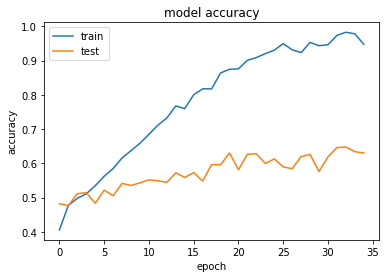

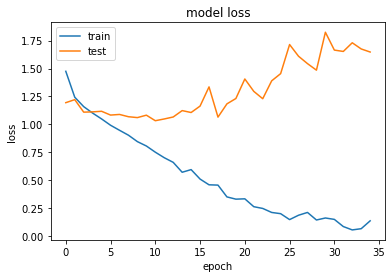

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
#Fine-tuning

model.add(Dense(5, 'sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predictions_one_hot = model.predict(inputs_test)
print(targets_test.shape, predictions_one_hot.shape)
# cm = confusion_matrix(targets_test, predictions_one_hot.argmax(axis=1))
# print(cm)
con_mat = tf.math.confusion_matrix(labels=targets_test, predictions=predictions_one_hot.argmax(axis=1)).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = [0,1,2,3,4], 
                     columns = [0,1,2,3,4])
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [3]:
signal, sr = librosa.load("../raw_dataset/files/BIG ROOM/01 Agus Zack _ Devbanz - Workout (Extended M.mp3") # len(signal) = 661794  # sr is 22050 by default 

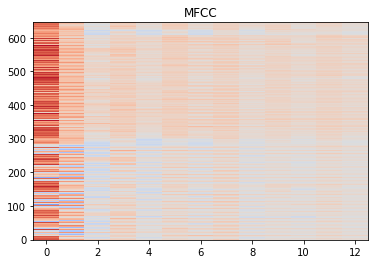

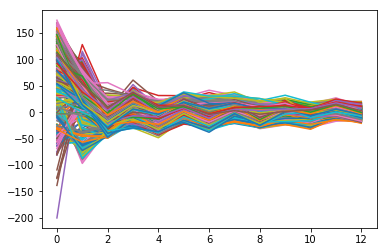

In [4]:
signal.shape[0]
mfcc = librosa.feature.mfcc(signal[0 : 22050*30],
                                                   sr = 22050,
                                                   n_fft = 4084,
                                                   n_mfcc = 13,
                                                   hop_length = 1024)
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# (rate,sig) = wav.read("file.wav")
mfcc_feat = mfcc

ig, ax = plt.subplots()
mfcc_data= np.swapaxes(mfcc_feat, 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
ax.set_title('MFCC')
#Showing mfcc_data
plt.show()
#Showing mfcc_feat
plt.plot(mfcc_feat)
plt.show()

In [6]:
mfcc.shape

(13, 646)

In [3]:
import ffmpeg
from moviepy.editor import VideoFileClip

video_filename = 'C:/Users/KRPTN/Pictures/Camera Roll/WIN_20210330_17_01_17_Pro.mp4'

def with_moviepy(filename):
    clip = VideoFileClip(filename)
    duration       = clip.duration
    fps            = clip.fps
    return duration, fps

duration, fps = with_moviepy(video_filename)

length = duration * fps
interval_sec = 10
start_timestamp = 0 
end_timestamp = fps * interval_sec

print(duration)
print(fps)

for i in range(int(length/(fps*interval_sec))):
    (
        ffmpeg
        .input(video_filename)
        .trim   (start_frame=start_timestamp, end_frame=end_timestamp) # output len --> 600 frames long
        .output ('C:/Users/KRPTN/Pictures/Camera Roll/WIN_20210330_17_01_17_Pro__'+ str(i) +'.mp4' )
        .run()
    )
    start_timestamp += end_timestamp
    end_timestamp += end_timestamp

68.47
30.0


In [ ]:
import os
dirs = 'C:/Users/KRPTN/Pictures/Camera Roll/WIN_20210330_17_01_17_Pro.mp4'
#Loop through all the genres
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        #ensure that we're not at the root level
    if dirpath not in dataset_path or True:

            #save the semantic label
        dirpath_components = dirpath.split('/')
        semantic_label = dirpath_components[-1]
        print('\nProcessing {}'.format(semantic_label))
            
            #process files for a specific genre 
        for f in filenames:
            if f.endswith('.mp4') or f.endswith('.MP4'):